In [82]:
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt


pd.set_option('display.max_columns', None)

df = pd.read_csv('data.csv', on_bad_lines="warn", delimiter=";")
df.head()

,Melding ID,Meldingstidspunkt,Meldingsdato,Meldingsklokkeslett,Starttidspunkt,Startdato,Startklokkeslett,Startposisjon bredde,Startposisjon lengde,Hovedområde start (kode),Hovedområde start,Lokasjon start (kode),Havdybde start,Stopptidspunkt,Stoppdato,Stoppklokkeslett,Varighet,Fangstår,Stopposisjon bredde,Stopposisjon lengde,Hovedområde stopp (kode),Hovedområde stopp,Lokasjon stopp (kode),Havdybde stopp,Trekkavstand,Redskap FAO (kode),Redskap FAO,Redskap FDIR (kode),Redskap FDIR,Hovedart FAO (kode),Hovedart FAO,Hovedart - FDIR (kode),Art FAO (kode),Art FAO,Art - FDIR (kode),Art - FDIR,Art - gruppe (kode),Art - gruppe,Rundvekt,Lengdegruppe (kode),Lengdegruppe,Bruttotonnasje 1969,Bruttotonnasje annen,Bredde,Fartøylengde
0,1497177,01.01.2018,01.01.2018,00:00,31.12.2017,31.12.2017,00:00,"-60,35","-46,133",NaN,NaN,NaN,-2740,01.01.2018,01.01.2018,00:00,1440,2018,"-60,4","-46,15",NaN,NaN,NaN,-805,5649.0,OTM,"Flytetrål, otter",53.0,Flytetrål,KRI,Antarktisk krill,2513.0,KRI,Antarktisk krill,2513.0,Antarktisk krill,506.0,Antarktisk krill,706714.0,5.0,28 m og over,9432.0,NaN,"19,87","133,88"
1,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,HAD,Hyse,1027.0,Hyse,202.0,Hyse,9594.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
2,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,COD,Torsk,1022.0,Torsk,201.0,Torsk,8510.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
3,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,GHL,Blåkveite,2313.0,Blåkveite,301.0,Blåkveite,196.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"
4,1497178,01.01.2018,01.01.2018,00:00,30.12.2017 23:21,30.12.2017,23:21,"74,885","16,048",20.0,Bjørnøya,7.0,-335,31.12.2017 04:16,31.12.2017,04:16,295,2017,"74,914","15,969",20.0,Bjørnøya,7.0,-334,3970.0,OTB,"Bunntrål, otter",51.0,Bunntrål,HAD,Hyse,1027.0,POK,Sei,1032.0,Sei,203.0,Sei,134.0,5.0,28 m og over,1476.0,NaN,"12,6","56,8"


As our hypothetical case, we imagine a government agency that is interested to predict wherther or not a given catch operation has caught endagered species of fish.
We use "https://artsdatabanken.no/lister/rodlisteforarter/2021?Name=&SortBy=ScientificName&Meta=Visited&Meta=scroll_658&IsCheck=Area&Area=N&IsCheck=Category&Category=CR&Category=EN&IsCheck=SpeciesGroups&SpeciesGroups=Fisker&IsCheck=Insekter" to find endangered species of fish. 
Three of these are included in the dataset:

1. Vanlig Uer
2. Blålange

Our strategy will be to trim unnecessary columns, turn species into boolean columns and have machine learning models give a probability that the catch operation has caught the endangered species, for each catch operation for each endangered species.

A lot of the data in the columns needs to be converted into boolean and number values, and some needs to be omitted due to inaccuracies. 



In [83]:
# df.info()

To start, we can safely drop columns where the data is present in other columns

In [84]:
df = df.drop(labels=["Meldingsdato","Meldingsklokkeslett","Startdato","Startklokkeslett", "Stoppdato", "Stoppklokkeslett", "Lengdegruppe (kode)", "Lengdegruppe"], axis=1)
df = df.drop(labels=["Hovedart FAO (kode)","Hovedart FAO","Hovedart - FDIR (kode)","Art - gruppe","Art - gruppe (kode)", "Art - FDIR (kode)", "Art - FDIR", "Redskap FDIR (kode)", "Redskap FDIR"], axis=1)



We notice that Start/Stop times are inconsistent. We therefore filter out Start/Stop times which do not contain ':'. This way we can trust the 'Varighet' column more.

Furthermore, 'Fartøylengde', 'Bredde', 'Startposisjon bredde', 'Startposisjon lengde', 'Stopposisjon bredde', 'Stopposisjon lengde' is written with ',' and not '.'. We change ',' to '.' and cast to float datatype.

In [85]:
df = df[df["Starttidspunkt"].str.contains(":")]
df = df[df["Stopptidspunkt"].str.contains(":")]

castable_columns = ["Fartøylengde", "Bredde", "Startposisjon bredde", "Startposisjon lengde", "Stopposisjon bredde", "Stopposisjon lengde"]

for column in castable_columns:
    df[column] = df[column].str.replace(",", ".").astype("float")



Next we need to convert the categorical column values we _do_ want to use into machine-readable data. In this case we use the built-in get_dummies function to create boolean columns.

In [86]:
# Turn categorical data into boolean values

species_columns = pd.get_dummies(df["Art FAO"], dtype="float")
species_columns_multiplied = species_columns.multiply(df["Rundvekt"], axis="index")

endangered_species_1 = species_columns_multiplied["Uer (vanlig)"]
endangered_species_2 = species_columns_multiplied["Blålange"]

print(endangered_species_1.sum())
print(endangered_species_2.sum())

df = pd.concat([df,endangered_species_1 ], axis=1)
df = pd.concat([df,endangered_species_2 ], axis=1)


tool_columns = pd.get_dummies(df["Redskap FAO"])
df = pd.concat([df,tool_columns], axis=1)




5185505.0
386032.0


In [87]:
# remove their original counterpart 
df = df.drop(["Art FAO", "Redskap FAO", "Art FAO (kode)", "Redskap FAO (kode)"], axis=1)

In order to use 'Bruttotonnasje' one option is to pick one of the columns, delete the other one and drop all n/a values.
We decided on a slightly different approach in order to preserve more rows.
We base the 'Bruttotonnasje' value on the standard 'Bruttotonnasje 1969' and instead of dropping rows right away, we check if the row contains a value in 'Bruttotonnasje annen', and use that.
Rows with missing values in both columns are dropped.


In [88]:

df = df.dropna(subset=["Bruttotonnasje 1969", "Bruttotonnasje annen"], how='all')
df["Bruttotonnasje"] = df["Bruttotonnasje 1969"].fillna(df["Bruttotonnasje annen"])
df = df.drop(["Bruttotonnasje 1969", "Bruttotonnasje annen"], axis=1)


It should be noted that 'Bruttotonnasje' is pretty well explained by 'Fartøylengde', although in a non-linear fashion. In light of this, we could probably omit either 'Bruttotonnasje' or the boat dimensions.
See graph.

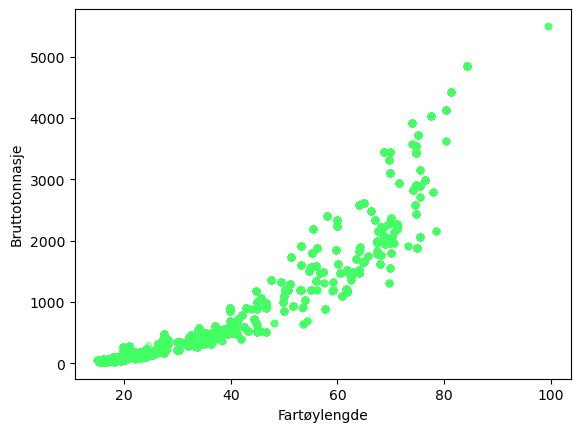

In [89]:

df.plot(kind = 'scatter', x = 'Fartøylengde', y = 'Bruttotonnasje', c="#43ff640d")
plt.show()

In [92]:
species_dict = {
    "Uer (vanlig)": "sum",
    "Blålange": "sum",
}
tool_dict= dict.fromkeys(tool_columns, "first")

catch_dict = {
        "Varighet": "mean",
        "Fangstår": "mean",
        "Trekkavstand": "mean",
        "Bredde": "mean",
        "Fartøylengde" : "mean",
        "Bruttotonnasje": "mean",
        "Rundvekt": "sum",
        "Havdybde start": "sum",
        "Havdybde stopp": "sum",
        "Startposisjon lengde": "sum",
        "Startposisjon bredde": "sum",
        "Stopposisjon lengde": "sum",
        "Stopposisjon bredde": "sum",

    }
master_dict = {**catch_dict, **tool_dict, **species_dict }

In [93]:
grouped = df.groupby(by=["Melding ID", "Starttidspunkt", "Stopptidspunkt"]).agg(master_dict).reset_index()
grouped.shape
grouped

,Melding ID,Starttidspunkt,Stopptidspunkt,Varighet,Fangstår,Trekkavstand,Bredde,Fartøylengde,Bruttotonnasje,Rundvekt,Havdybde start,Havdybde stopp,Startposisjon lengde,Startposisjon bredde,Stopposisjon lengde,Stopposisjon bredde,Andre liner,Annen trål (udefinert),Boat /vessel seines -Pair seines,Bunntrål (uspes),"Bunntrål, otter","Bunntrål, par","Bunntrål, reke",Dorg/harp/snik,Encircling gillnets*,"Flytetrål, otter","Flytetrål, par","Flytetrål, reke","Flytetrål, uspesifisert",Gillnets and entangling nets (unspec)*,"Harpun,div.","Juksa/pilk, manuell",Otter dobbeltrål,"Partrål, uspesifisert",Settegarn,Setteline,"Skrape, mekanisert",Snurpenot/ringnot,"Snurpenot/ringnot, et fartøy","Snurpenot/ringnot, to fartøy",Snurrevad,"Snurrevad, dansk","Snurrevad, skotsk",Teiner,Udefinert garn,Udefinert trål,Uer (vanlig),Blålange
0,1497178,30.12.2017 23:21,31.12.2017 04:16,295.0,2017.0,3970.0,12.60,56.80,1476.0,18434.0,-1340,-1336,64.192,299.540,63.876,299.656,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
1,1497178,31.12.2017 05:48,31.12.2017 10:15,267.0,2017.0,11096.0,12.60,56.80,1476.0,16062.0,-2418,-1662,95.208,449.460,97.488,449.406,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
2,1497178,31.12.2017 11:34,31.12.2017 16:49,315.0,2017.0,10215.0,12.60,56.80,1476.0,17878.0,-2076,-2976,96.336,449.298,94.452,449.544,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,37.0,0.0
3,1497178,31.12.2017 17:44,31.12.2017 21:47,243.0,2017.0,3214.0,12.60,56.80,1476.0,13780.0,-886,-716,31.570,149.862,31.788,149.852,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
4,1497229,01.01.2018 10:01,01.01.2018 11:04,63.0,2018.0,1269.0,5.06,19.10,51.0,4.0,-71,-56,12.972,67.828,12.942,67.827,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98238,1800286,31.12.2018 15:07,31.12.2018 18:59,232.0,2018.0,2400.0,10.50,39.79,691.0,9023.0,-764,-712,88.564,283.448,88.752,283.508,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0.0,0.0
98239,1800291,30.12.2018 23:20,31.12.2018 04:21,301.0,2018.0,13284.0,12.60,57.30,1483.0,11105.0,-1544,-2728,114.360,612.072,117.432,611.448,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,51.0,0.0
98240,1800291,31.12.2018 05:40,31.12.2018 11:25,345.0,2018.0,44035.0,12.60,57.30,1483.0,10017.0,-1708,-2093,104.524,534.695,95.494,536.480,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,51.0,0.0
98241,1800291,31.12.2018 12:53,31.12.2018 18:21,328.0,2018.0,41216.0,12.60,57.30,1483.0,10427.0,-1400,-1445,69.000,383.030,64.100,384.495,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,102.0,0.0


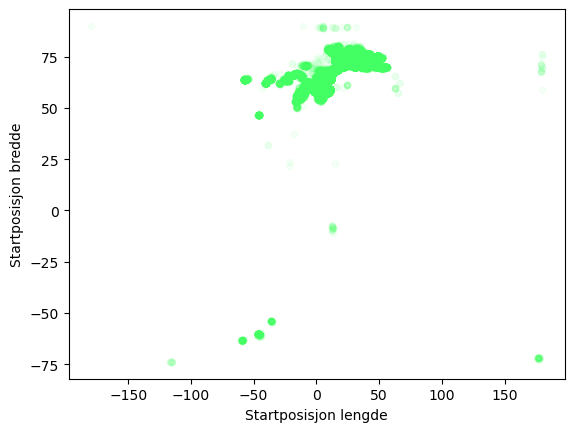

In [94]:
df.plot(kind = 'scatter', x = 'Startposisjon lengde', y = 'Startposisjon bredde', c="#43ff640d")
plt.show()

In [95]:
grouped.corr(method="pearson", numeric_only=True)["Uer (vanlig)"]

Melding ID                                0.013067
Varighet                                 -0.013552
Fangstår                                  0.000585
Trekkavstand                              0.002846
Bredde                                    0.092497
Fartøylengde                              0.079899
Bruttotonnasje                            0.102637
Rundvekt                                 -0.011323
Havdybde start                           -0.082048
Havdybde stopp                           -0.087472
Startposisjon lengde                      0.079031
Startposisjon bredde                      0.070672
Stopposisjon lengde                       0.079375
Stopposisjon bredde                       0.070738
Andre liner                               0.001675
Annen trål (udefinert)                   -0.002566
Boat /vessel seines -Pair seines         -0.005842
Bunntrål (uspes)                         -0.016722
Bunntrål, otter                           0.105627
Bunntrål, par                  

**Supervised Learning**

TODO: Preprocessing of data with reasoning 

TODO: Build 3 supervised learning models, one of which needs to be a deep learning model

KNN (regressor), nevralt nett (deep learning, pytorch, keras, tensorflow), spicy learning model 

**Unsupervised Learning (Clustering Model)**

TODO: Preprocessing of data with reasoning

TODO: Build Clustering Model 

**Results and comments**

TODO: "write a summary of your results, and discuss consequences of such results."
